In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Convolutional Neural Networks

Used mainly with images, CNNs are a good approach to reduce number of input parameters ...
Guided by conservation of locality and .. CNNs sound like a good choice for SCA.

In [8]:
import random
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import os
import numpy as np
import h5py
import tensorflow as tf
import keras
from datetime import datetime
import keras_tuner as kt
from tqdm.notebook import tqdm
import tensorflow_addons as tfa
import keras_tuner as kt

In [9]:
from utils.data_preparation import SCAML_Dataset
from utils.AES import AES
from utils.training import SCA_Trainer

In [10]:
EXECUTE_IN_COLAB = False
ATTACK_ALGORITHM = 'tinyaes'

if EXECUTE_IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    colab_root_path = '/content/drive/MyDrive/'
    
    training_data_path = colab_root_path + 'datasets/tinyaes/train'
    testing_data_path = colab_root_path + 'datasets/tinyaes/test'
    
    save_models_root_path = colab_root_path + 'models/'
    
    log_root_path = colab_root_path + 'logs/'
else:
    data_root_path = './data/SCA_datasets/datasets/' + ATTACK_ALGORITHM
    
    training_data_path = data_root_path + '/train'
    testing_data_path = data_root_path + '/test'
    
    save_models_root_path = './models/'
    
    log_root_path = './logs/'

## Load data

In [11]:
dataset = SCAML_Dataset()

In [12]:
dataset.create_dataset(training_data_path, attack_point='sub_bytes_out', trace_length=8000)
dataset.create_dataset(testing_data_path, attack_point='sub_bytes_out', attack=True, trace_length=8000)

256it [00:01, 178.56it/s]
Loading shards: 100%|████████████████████████████████████████████████████████████████| 256/256 [00:45<00:00,  5.59it/s]
256it [00:01, 132.30it/s]
Loading shards: 100%|████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.51it/s]


In [13]:
training_data = dataset.get_profiling_dataset(attack_byte=0)

In [14]:
(X_profiling, y_profiling) = training_data.X, training_data.y

In [15]:
X_profiling.shape[1:]

TensorShape([8000, 1])

In [51]:
attack_data = []
for i in range(256):
    attack_data.append(dataset.get_attack_dataset(i, attack_byte=0))

In [57]:
len(attack_data)

256

In [70]:
attack_traces = [x.X for x in attack_data]
attack_traces = tf.concat(attack_traces, axis=0)

In [71]:
attack_y = [y.y for y in attack_data]
attack_y = tf.concat(attack_y, axis=0)

## Define model architecture

As using Batch normalization proved effective with MLP, it will be used in the base configuration of CNN aswell.

In [16]:
with tf.device('/cpu:0'):
    # Input
    inputs = keras.Input(name='input_layer', shape = X_profiling.shape[1:])

    # Convolutional layer 1
    x = keras.layers.Conv1D(name='conv_layer_1', filters=64, kernel_size=5, activation='relu')(inputs)
    # Max pooling layer 1
    x = keras.layers.MaxPooling1D(pool_size=3)(x)
    
    x = keras.layers.BatchNormalization()(x)

    # Convolutional layer 2
    x = keras.layers.Conv1D(name='conv_layer_2', filters=32, kernel_size=5, activation='relu')(x)
    # Max pooling layer 2
    x = keras.layers.MaxPooling1D(pool_size=3)(x)
    
    x = keras.layers.BatchNormalization()(x)

    # Convolutional layer 3
    x = keras.layers.Conv1D(name='conv_layer_3', filters=32, kernel_size=5, activation='relu')(x)
    # Max pooling layer 3
    x = keras.layers.MaxPooling1D(pool_size=3)(x)

    x = keras.layers.Flatten()(x)
    
    # Hidden layer 1
    x = keras.layers.Dense(name='hidden_layer_1', units=1500, activation='relu')(x)

    # Hidden layer 2
    x = keras.layers.Dense(name='hidden_layer_2', units=1000, activation='relu')(x)
    
    # Hidden layer 3
    x = keras.layers.Dense(name='hidden_layer_3', units=500, activation='relu')(x)

    # Output layer
    outputs = keras.layers.Dense(name='output_layer', units=256, activation='softmax')(x)

    CNN = keras.Model(inputs=inputs, outputs=outputs, name='CNN_base')

    CNN.summary()

Model: "CNN_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 8000, 1)]         0         
                                                                 
 conv_layer_1 (Conv1D)       (None, 7996, 64)          384       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2665, 64)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 2665, 64)         256       
 ormalization)                                                   
                                                                 
 conv_layer_2 (Conv1D)       (None, 2661, 32)          10272     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 887, 32)          0  

In [17]:
CNN_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)

CNN.compile(loss='categorical_crossentropy', 
                 optimizer=CNN_optimizer, 
                 metrics=['accuracy'])

In [18]:
CNN_base_trainer = SCA_Trainer()

In [19]:
CNN_base_trainer.train_model(CNN, dataset, attack_byte=0, batch_size=200, epochs=15, validation_split=0.2, verbose=1)

Epoch 1/15
263/263 [==============================] - 293s 1s/step - loss: 5.5695 - accuracy: 0.0037 - val_loss: 5.5529 - val_accuracy: 0.0045
Epoch 2/15
263/263 [==============================] - 276s 1s/step - loss: 5.5276 - accuracy: 0.0066 - val_loss: 5.5254 - val_accuracy: 0.0071
Epoch 3/15
263/263 [==============================] - 277s 1s/step - loss: 5.1073 - accuracy: 0.0225 - val_loss: 4.8165 - val_accuracy: 0.0253
Epoch 4/15
263/263 [==============================] - 268s 1s/step - loss: 4.2533 - accuracy: 0.0587 - val_loss: 4.0659 - val_accuracy: 0.0661
Epoch 5/15
263/263 [==============================] - 266s 1s/step - loss: 3.6324 - accuracy: 0.0957 - val_loss: 3.8431 - val_accuracy: 0.0628
Epoch 6/15
263/263 [==============================] - 267s 1s/step - loss: 3.2428 - accuracy: 0.1243 - val_loss: 3.4758 - val_accuracy: 0.0924
Epoch 7/15
263/263 [==============================] - 266s 1s/step - loss: 2.9936 - accuracy: 0.1463 - val_loss: 3.3061 - val_accuracy: 0.1059

Training data was greatly reduced to improve training size (only 10% of the original trace was used). Because model achieved accuracy that is greater than random guessing, it seems that the chunk of data on which it trained was enough to attack the first key byte. Real attack would have to use larger portion of the traces because AES operations on other key bytes probably take place later. One of the proposed advantages of using Convolutional NNs for SCA is that less preprocessing is needed because the network itself can learn to 'preprocess' raw data.

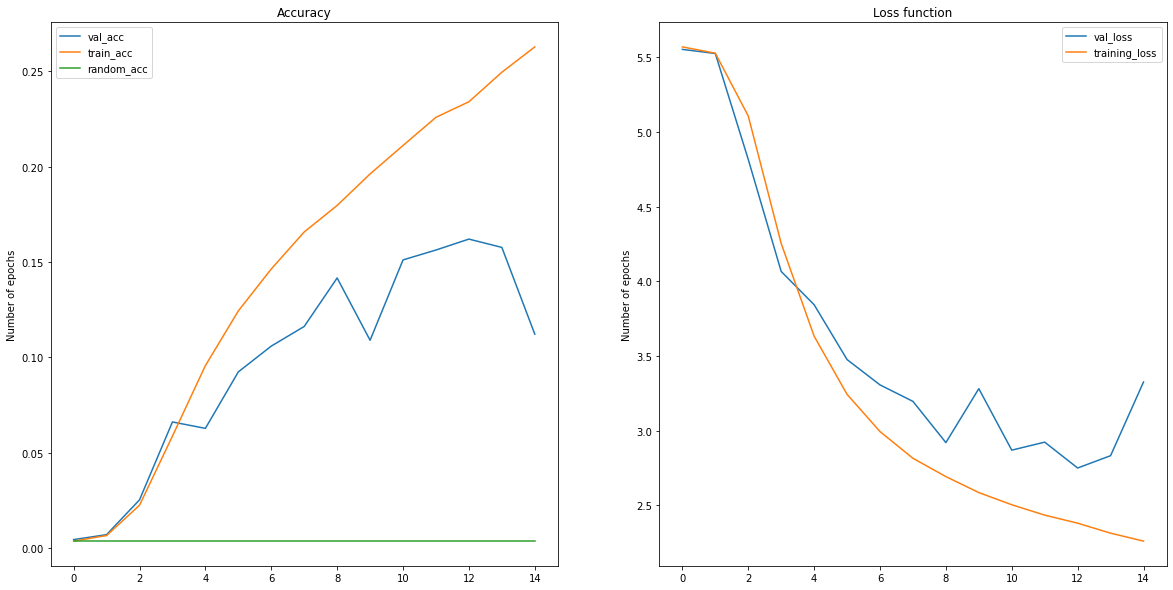

In [20]:
CNN_base_trainer.plot_model_history()

## Evaluate the model's key recovery efficency

As the model learned to classify better than random, it makes sense to evaluate key byte recovery.

In [21]:
ATTACK_BYTE=0

  0%|          | 0/50 [00:00<?, ?it/s]

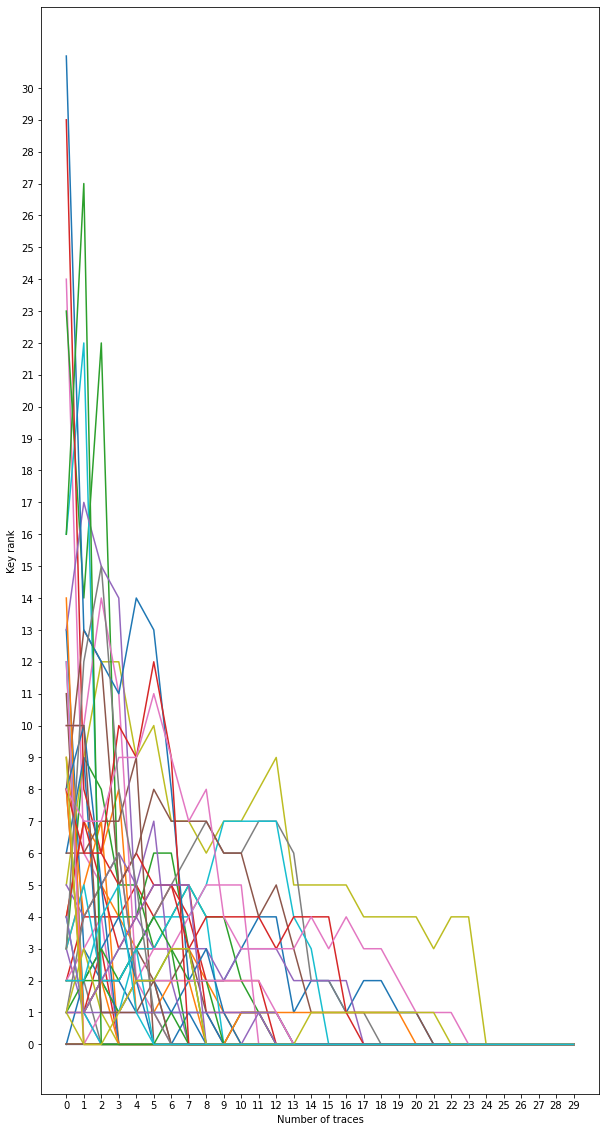

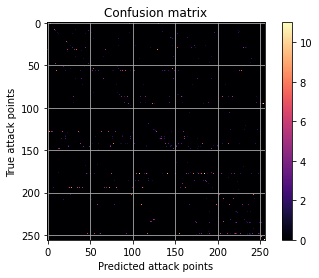

In [22]:
CNN_base_trainer.evaluate_model(CNN,
                 dataset,
                 attack_byte=ATTACK_BYTE,
                 traces_per_chunk = 30,
                 keys_to_attack=50,
                 verbose=0)

Confusion matrix looks slightly better than the one produced by MLP, but it's still far from crisp diagonal that was produced by model loaded from [SCAAML repository](https://github.com/google/scaaml). Key recovery success is a lot better than MLP classifier's.

Model achieved average accuracy of 3.36% on 50 different keys (30 traces each)
Maximum key recovery success of 100.0 achieved with 24 traces


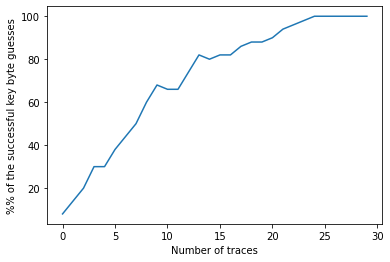

In [23]:
CNN_base_trainer.evaluation_summary()

Even with accuracy of only 4.98% (predicting intermediate values), model was able to correctly guess all key bytes using only 26 traces. This has to do with the way final predictions are made.

----

## Hypertuning

As model accuracy could be a lot better, hypertuning will be applied. This time, only Hyperband algorithm will be used for searching the hyperparameter space.

In [26]:
# Setup the hyperparam search space

min_conv_layers = 2
max_conv_layers = 4

min_filters = 32
max_filters = 96

min_kernel_size = 5
max_kernel_size = 10

min_pool_size = 2
max_pool_size = 4

min_fc_layers = 2
max_fc_layers = 4

min_units = 500
max_units = 1500

In [24]:
# Meta model builder
def build_model(hp):
    
    inputs = keras.Input(shape = X_profiling.shape[1:])
    
    x = inputs
    
    no_conv_layers = hp.Int('num_conv_layers', min_value=min_conv_layers, max_value=max_conv_layers)
    no_filters = hp.Int('num_filters', min_value=min_filters, max_value=max_filters, step=32)
    kernel_size = hp.Int('kernel_size', min_value=min_kernel_size, max_value=max_kernel_size, step=5)
    pool_size = hp.Int('pool_size', min_value=min_pool_size, max_value=max_pool_size)
    
    for conv_layer in range(no_conv_layers):
        # Each new convolution produces smaller output (except if kernel_size == 1):
        # output_size = input_size - kernel_size + 1
        # In order to build valid models, some values should be ignored
        if(x.shape[1] - 1 <= kernel_size):
            break

        # Stack convolutional layers
        x = keras.layers.Conv1D(name=f'conv_layer_{conv_layer}',
                                filters=no_filters+conv_layer*32, # Increase number of features to monitor
                                kernel_size=kernel_size,
                                activation='relu')(x)
        x = keras.layers.MaxPooling1D(pool_size=pool_size)(x)
        x = keras.layers.BatchNormalization()(x)
        
    x = keras.layers.Flatten()(x)
        
    no_fc_layers = hp.Int('fc_layers', min_value=min_fc_layers, max_value=max_fc_layers)
    no_units = hp.Int('fc_units', min_value=min_units, max_value=max_units, step=500)
    
    for fc_layer in range(no_fc_layers):
        # Stack fully connected layers
        x = keras.layers.Dense(name=f'fc_layer_{fc_layer}', units=no_units, activation='relu')(x)
        x = keras.layers.BatchNormalization()(x)

    outputs = keras.layers.Dense(units=256, activation='softmax')(x)
    
    model_name = f'HyperCNN_{no_conv_layers}_cls_' \
                 f'{no_filters}_fs_' \
                 f'{kernel_size}_ks_' \
                 f'{pool_size}_ps_' \
                 f'{no_fc_layers}_fcs_' \
                 f'{no_units}_units' + datetime.now().strftime("%Y-%d-%m_%H-%M")
    model = keras.Model(name=model_name, inputs=inputs, outputs=outputs)
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5, 3e-2, 3e-3, 3e-4, 3e-5, 5e-2, 5e-3, 5e-4, 5e-5])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss="categorical_crossentropy",
                    metrics=['accuracy',
                             'Recall'])

    return model

In [27]:
h_tuner = kt.Hyperband(
    hypermodel=build_model,
    objective='val_accuracy',
    max_epochs=5,
    hyperband_iterations=3,
    directory=log_root_path + '/hyperparam_tuning/Hyperband/CNN/'
)

h_tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project ./logs//hyperparam_tuning/Hyperband/CNN/untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from ./logs//hyperparam_tuning/Hyperband/CNN/untitled_project\tuner0.json
Search space summary
Default search space size: 7
num_conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': None}
num_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 96, 'step': 32, 'sampling': None}
kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 10, 'step': 5, 'sampling': None}
pool_size (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': None}
fc_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': None}
fc_units (Int)
{'default': None, 'conditions': [], 'min_value': 500, 'max_value': 1500, 'step': 500, 'sampling': None}
learning_rate (Choice)

In [ ]:
tensorboard_path  = log_root_path + '/hyperparam_tuning/Hyperband/CNN' + datetime.now().strftime("%Y-%d-%m_%H-%M")

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
tensorboard_callback = tf.keras.callbacks.TensorBoard(tensorboard_path)

h_tuner.search(X_profiling, 
             y_profiling,
             epochs=5,
             validation_split=0.2,
             callbacks=[early_stop_callback,
                       tensorboard_callback]
            )

---
Hypertuning can be visualized in real time using Tensorboard.

From anaconda prompt/terminal:

`conda activate <env-name>`

`cd <repo-root>`

`tensorboard --logdir ./logs/hyperparam_tuning/Hyperband/CNN`

---

After 10 trials of the search algorithm, results looked like this:

|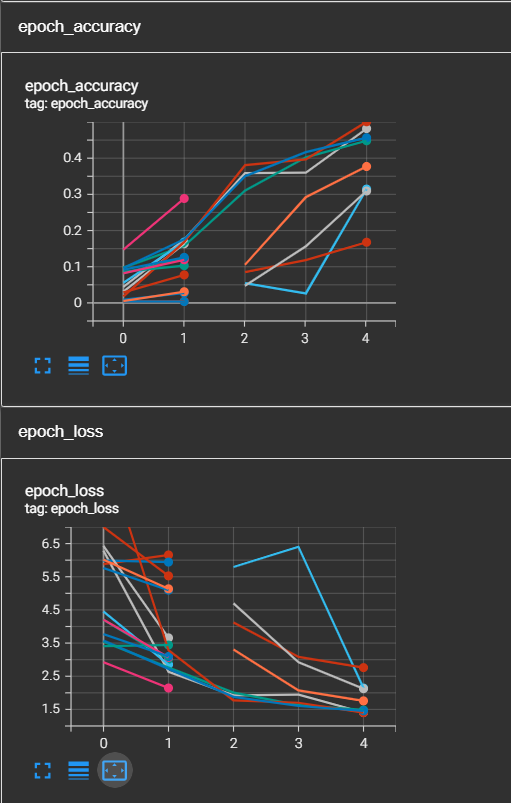|
|:--:|
|Hypertuning visualization|

It looks like most of the hyper models are able to improve relatively quickly contrary to MLP models which took a lot more time and were a lot more unstable and innaccurate.

## Compile and train the best model

It is obvious that the hyperparameter search successfully found models with huge improvement in accuracy (over 50% accuracy is great). Best hyperparams will be used to construct model:

In [28]:
best_hyperparams = h_tuner.get_best_hyperparameters()[0]
best_hyperparams.values

{'num_conv_layers': 3,
 'num_filters': 32,
 'kernel_size': 10,
 'pool_size': 4,
 'fc_layers': 2,
 'fc_units': 500,
 'learning_rate': 0.003,
 'tuner/epochs': 5,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [29]:
best_CNN = h_tuner.hypermodel.build(best_hyperparams)

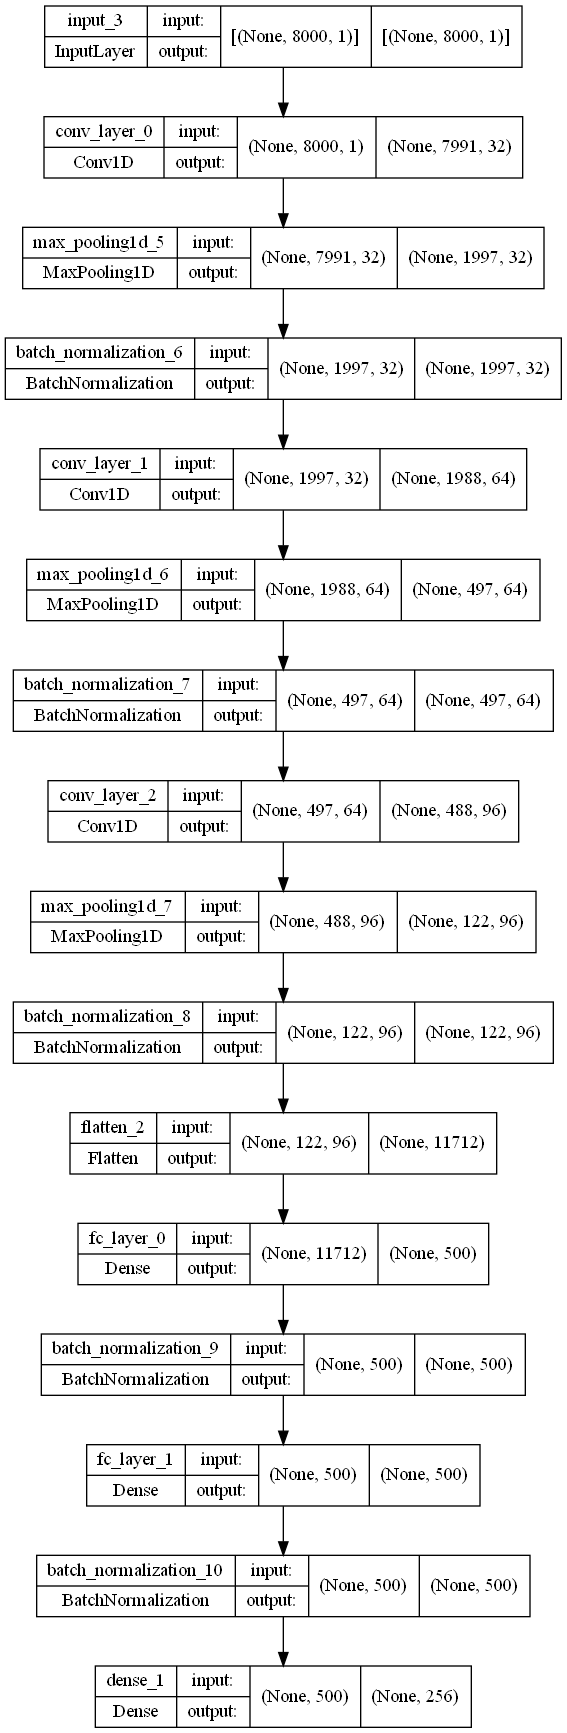

In [30]:
tf.keras.utils.plot_model(best_CNN, show_shapes=True)

In [31]:
ATTACK_POINT = 'sub_bytes_out'
ATTACK_BYTE = 0

trainer = SCA_Trainer()

trainer.train_model(best_CNN, dataset, attack_byte=ATTACK_BYTE, batch_size=32, epochs=15, validation_split=0.2, tag='Hypertuner_BestMLP')

Epoch 1/15
1639/1639 [==============================] - 283s 171ms/step - loss: 3.5765 - accuracy: 0.0943 - recall: 0.0153 - val_loss: 3.1977 - val_accuracy: 0.1007 - val_recall: 0.0317
Epoch 2/15
1639/1639 [==============================] - 260s 159ms/step - loss: 2.8566 - accuracy: 0.1511 - recall: 0.0297 - val_loss: 4.9635 - val_accuracy: 0.1500 - val_recall: 0.0719
Epoch 3/15
1639/1639 [==============================] - 253s 154ms/step - loss: 1.1897 - accuracy: 0.5575 - recall: 0.4167 - val_loss: 1.4874 - val_accuracy: 0.4868 - val_recall: 0.3933
Epoch 9/15
1639/1639 [==============================] - 252s 154ms/step - loss: 1.0976 - accuracy: 0.5904 - recall: 0.4639 - val_loss: 1.2016 - val_accuracy: 0.5741 - val_recall: 0.4611
Epoch 10/15
1639/1639 [==============================] - 261s 159ms/step - loss: 1.0305 - accuracy: 0.6158 - recall: 0.4995 - val_loss: 3.9652 - val_accuracy: 0.5430 - val_recall: 0.4347
Epoch 11/15
1639/1639 [==============================] - 270s 165ms/s

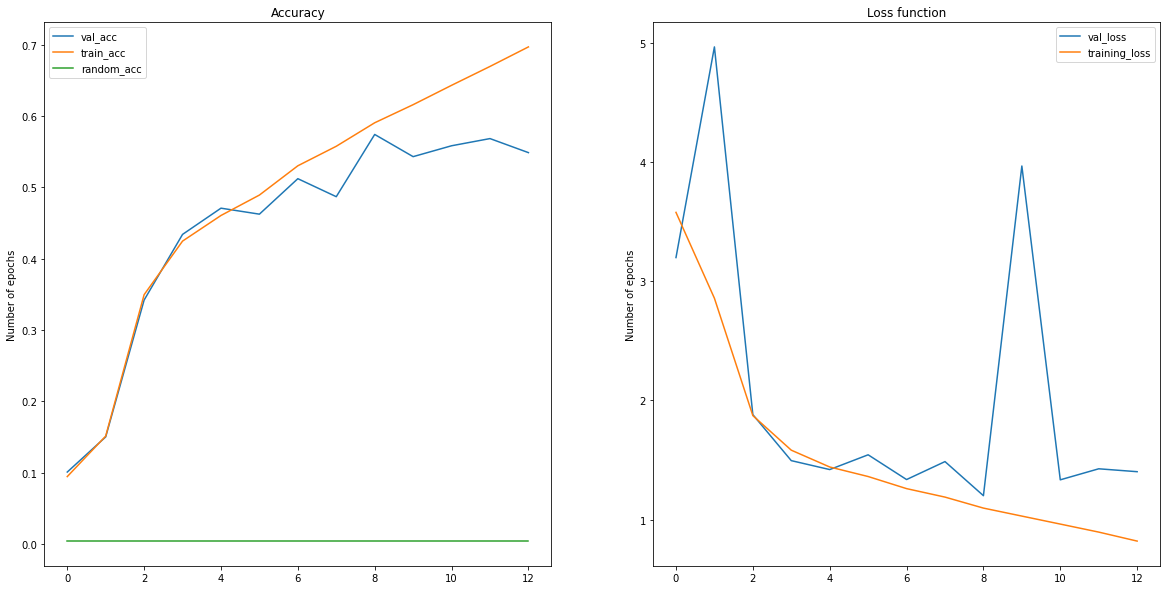

In [32]:
trainer.plot_model_history()

Model generalizes very well (validation and training accuracies are pretty close). Accuracy is also greatly improved compared to all of the previously trained models.

### Evaluate key recovery success

With greater accuracy, more effective key recovery is expected. This means that less traces are needed to make correct predictions for all keys.

  0%|          | 0/256 [00:00<?, ?it/s]

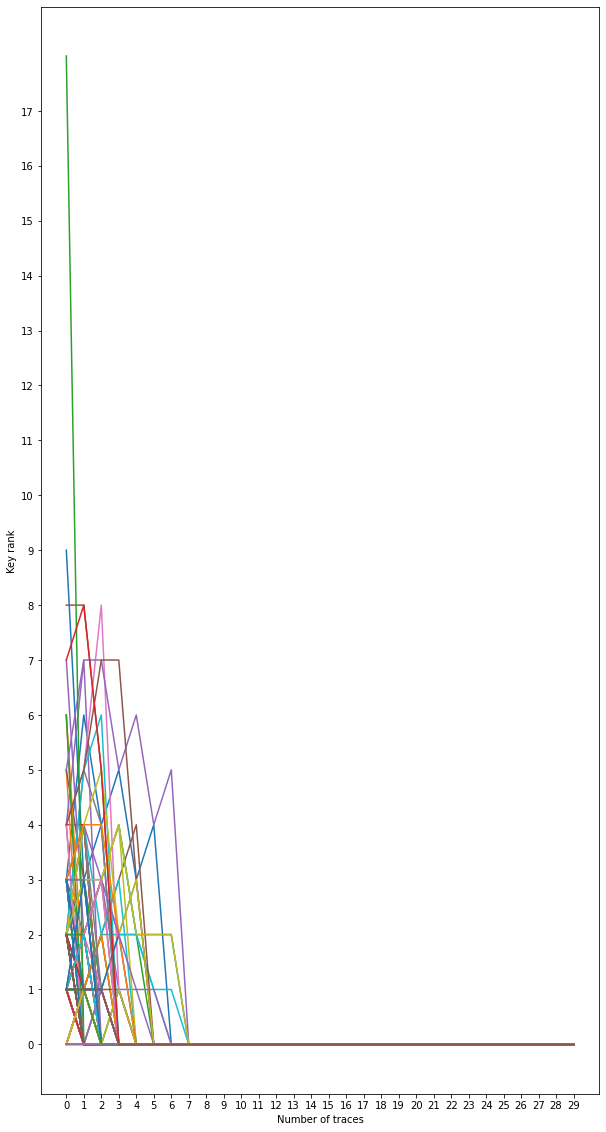

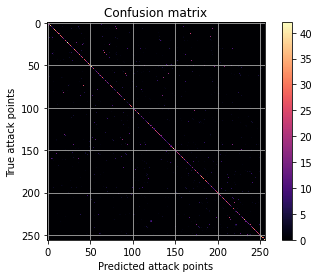

In [33]:
trainer.evaluate_model(best_CNN,
                       dataset,
                       attack_byte=ATTACK_BYTE,
                       traces_per_chunk = 30,
                       keys_to_attack=256,
                       verbose=0)

Confusion matrix is very clearly defined because of the great model accuracy, and key ranks also drop very fast. This means that less than 10 traces are needed to correctly recover the key byte. Another thing worth noting is that there is only a couple of highly ranked keys, but all of them, even the highest, drop to zero pretty quickly. 

Model achieved average accuracy of 16.0859375% on 256 different keys (30 traces each)
Maximum key recovery success of 100.0 achieved with 7 traces


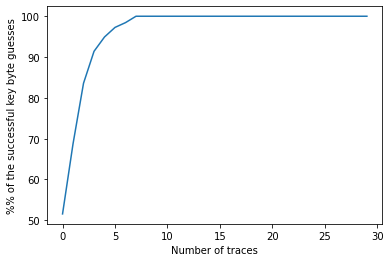

In [34]:
trainer.evaluation_summary()

Tensorboard training visualization for `HyperCNN_3_cls_32_fs_10_ks_4_ps_2_fcs_500_units2022-29-08_12-182022-29-08_12-20Hypertuner_BestMLP`: 

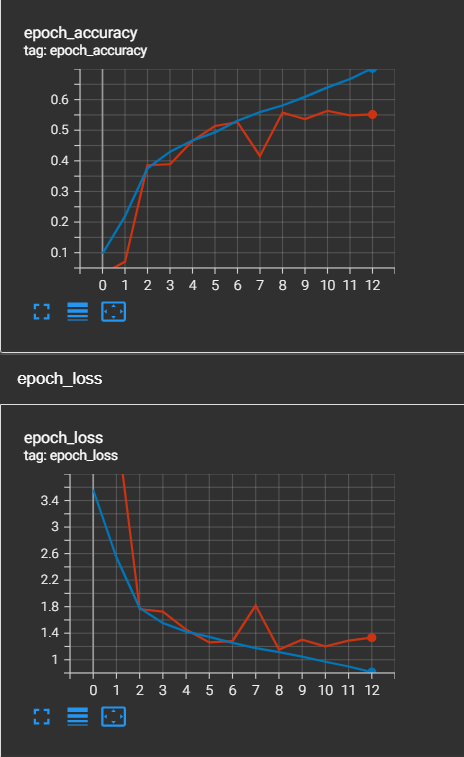

## Compare the results with SCAAML pretrained model

In this section, pretrained model from SCAAML repository will be loaded, and it's performance will be compared to `best_CNN` model.

In [35]:
scaaml_model_path = save_models_root_path + 'stm32f415-tinyaes-cnn-v10-ap_sub_bytes_out-byte_0-len_10000'
scaaml_pretrained = tf.keras.models.load_model(scaaml_model_path)

NOTE: SCAAML model had traces with higher resolution for training, but performances will be compared either way.

In [36]:
scaaml_dataset = SCAML_Dataset()

scaaml_dataset.create_dataset(training_data_path, attack_point='sub_bytes_out', trace_length=10000)
scaaml_dataset.create_dataset(testing_data_path, attack_point='sub_bytes_out', attack=True, trace_length=10000)

256it [00:01, 149.49it/s]
Loading shards: 100%|████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.53it/s]
256it [00:01, 165.17it/s]
Loading shards: 100%|████████████████████████████████████████████████████████████████| 256/256 [00:49<00:00,  5.18it/s]


  0%|          | 0/256 [00:00<?, ?it/s]

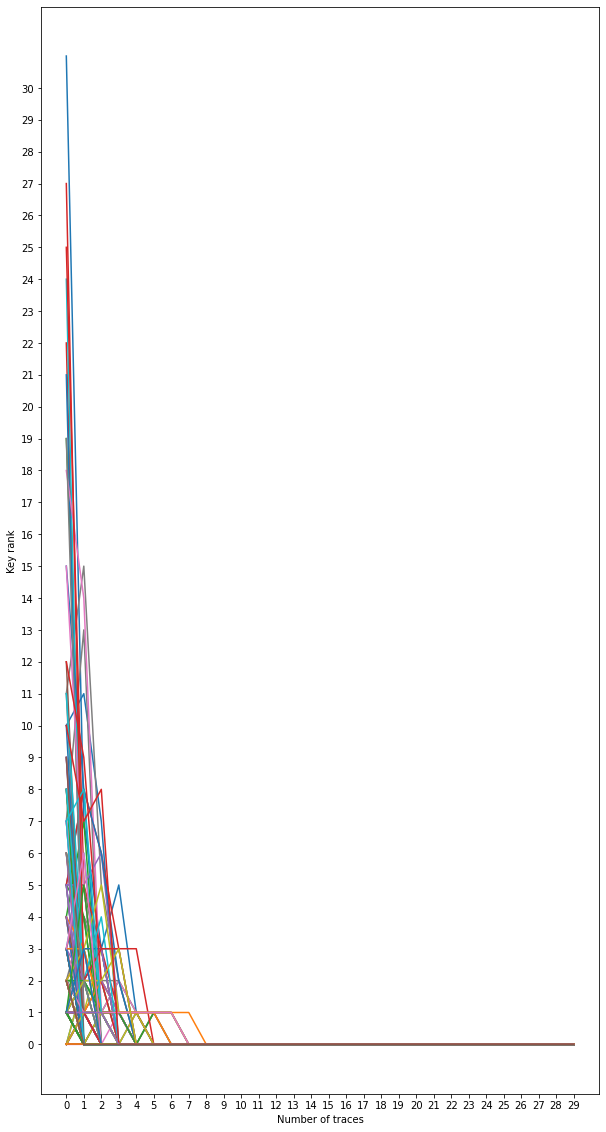

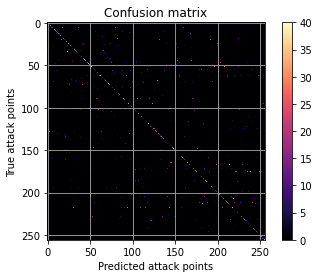

In [37]:
ATTACK_POINT = 'sub_bytes_out'
ATTACK_BYTE = 0

scaaml_trainer = SCA_Trainer()

scaaml_trainer.evaluate_model(scaaml_pretrained,
                              scaaml_dataset,
                              attack_byte=ATTACK_BYTE,
                              traces_per_chunk = 30,
                              keys_to_attack=256,
                              verbose=0)

Model achieved average accuracy of 9.3671875% on 256 different keys (30 traces each)
Maximum key recovery success of 100.0 achieved with 8 traces


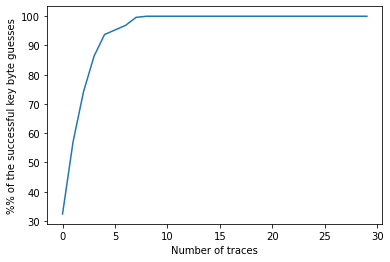

In [38]:
scaaml_trainer.evaluation_summary()

Both models are very performant, but manually trained CNN was slightly better, and this could be due the fact that it was trained on a slightly smaller traces.

# Train and evaluate on the whole key

Up until this point, all attacks were focused on attacking a single key byte, which is of course not enough for the real world application, but it serves as a good starting point for hyperparameter tuning and success evaluation. In this section, 16 models will be trained using best hyperparameters.

In [39]:
full_trainer_list = []
models_list = []

ATTACK_POINT = 'sub_bytes_out'

# Start from 1 because byte 0 model is already trained
for attack_byte in range(1,16):
    m = h_tuner.hypermodel.build(best_hyperparams)
    
    t = SCA_Trainer()
    t.train_model(m, dataset, attack_byte=attack_byte, batch_size=32, epochs=10, validation_split=0.2, tag=f'FullCNN_recovery_{attack_byte}')
    
    models_list.append(m)
    full_trainer_list.append(t)

Epoch 1/10
1639/1639 [==============================] - 272s 165ms/step - loss: 3.4453 - accuracy: 0.1274 - recall: 0.0282 - val_loss: 2.5498 - val_accuracy: 0.2507 - val_recall: 0.1192
Epoch 2/10
1639/1639 [==============================] - 267s 163ms/step - loss: 2.2325 - accuracy: 0.2870 - recall: 0.1046 - val_loss: 3.6074 - val_accuracy: 0.1330 - val_recall: 0.0724
Epoch 3/10
1639/1639 [==============================] - 269s 164ms/step - loss: 2.0174 - accuracy: 0.3314 - recall: 0.1435 - val_loss: 6.9044 - val_accuracy: 0.1087 - val_recall: 0.0722
Epoch 4/10
1639/1639 [==============================] - 262s 160ms/step - loss: 1.7809 - accuracy: 0.3881 - recall: 0.2000 - val_loss: 2.0940 - val_accuracy: 0.3469 - val_recall: 0.1974
Epoch 5/10
1639/1639 [==============================] - 256s 156ms/step - loss: 1.5448 - accuracy: 0.4634 - recall: 0.2822 - val_loss: 1.6040 - val_accuracy: 0.4398 - val_recall: 0.3024
Epoch 6/10
1639/1639 [==============================] - 255s 155ms/ste

In [40]:
# add previously trained CNN to list
models_list.insert(0, best_CNN)
full_trainer_list.insert(0, trainer)

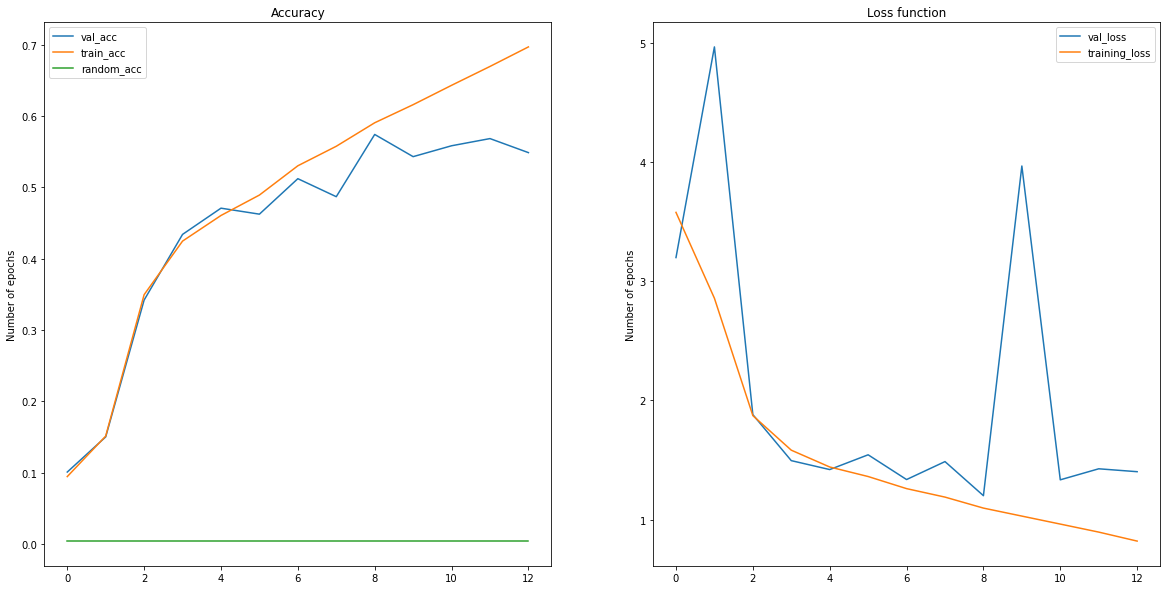

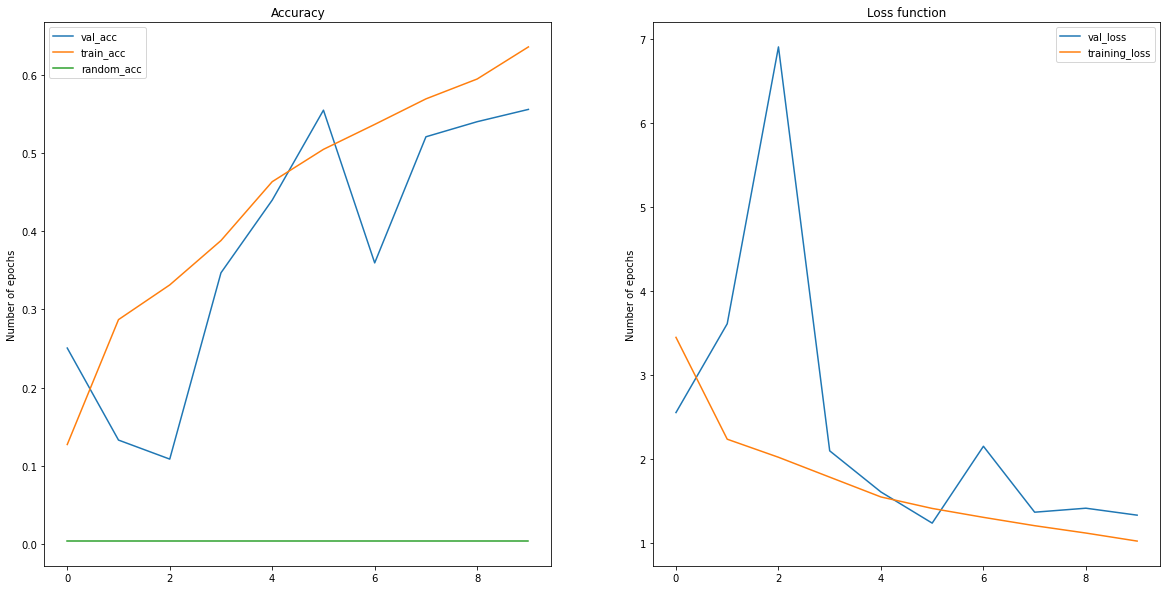

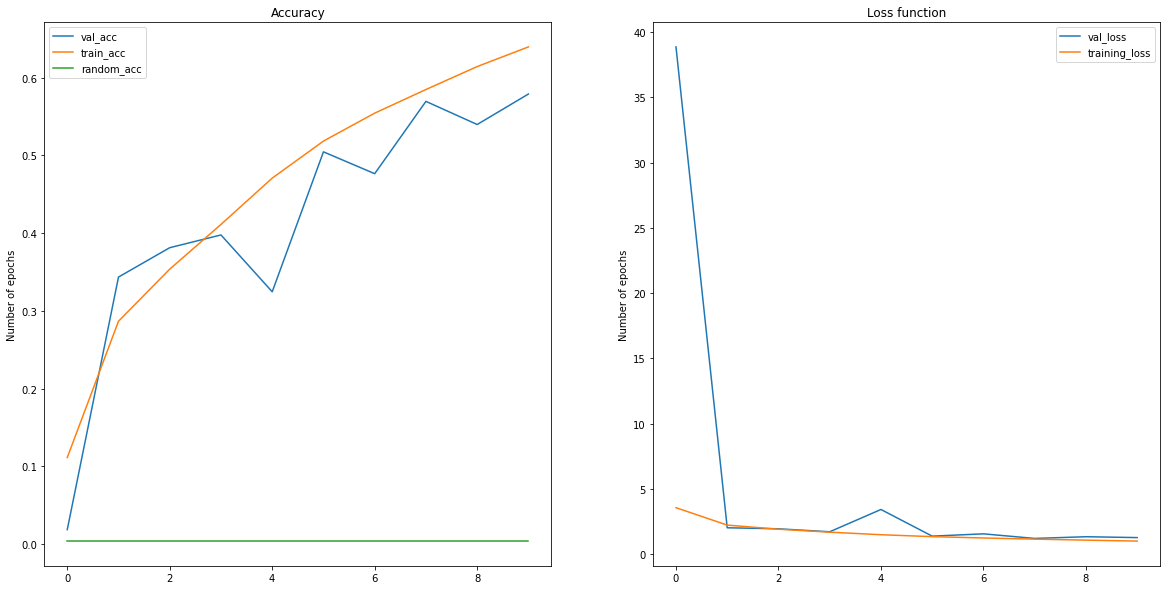

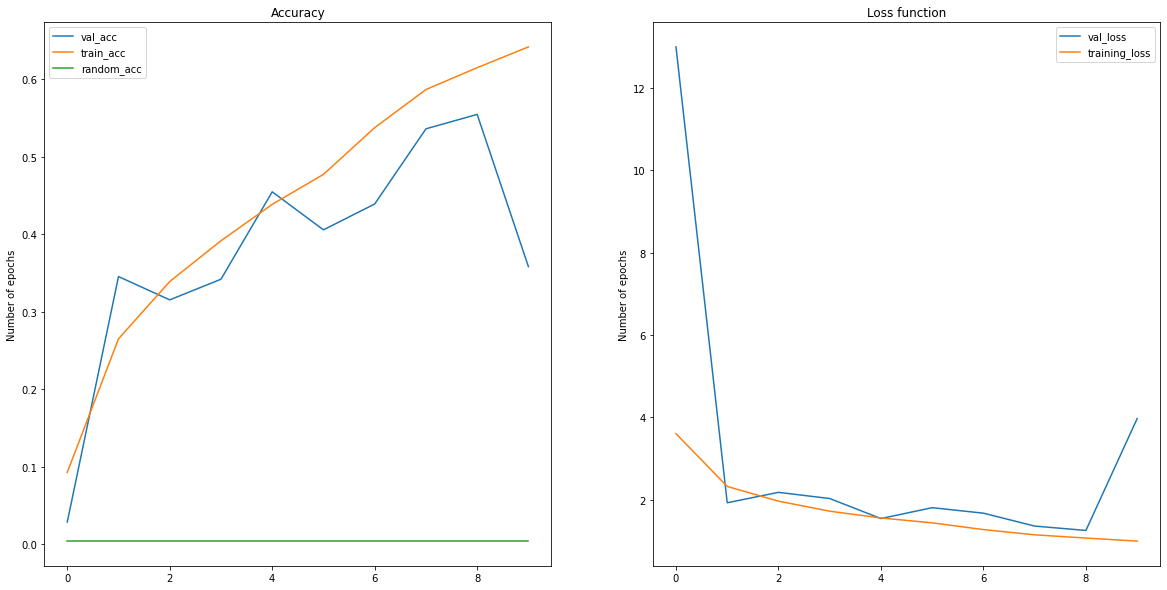

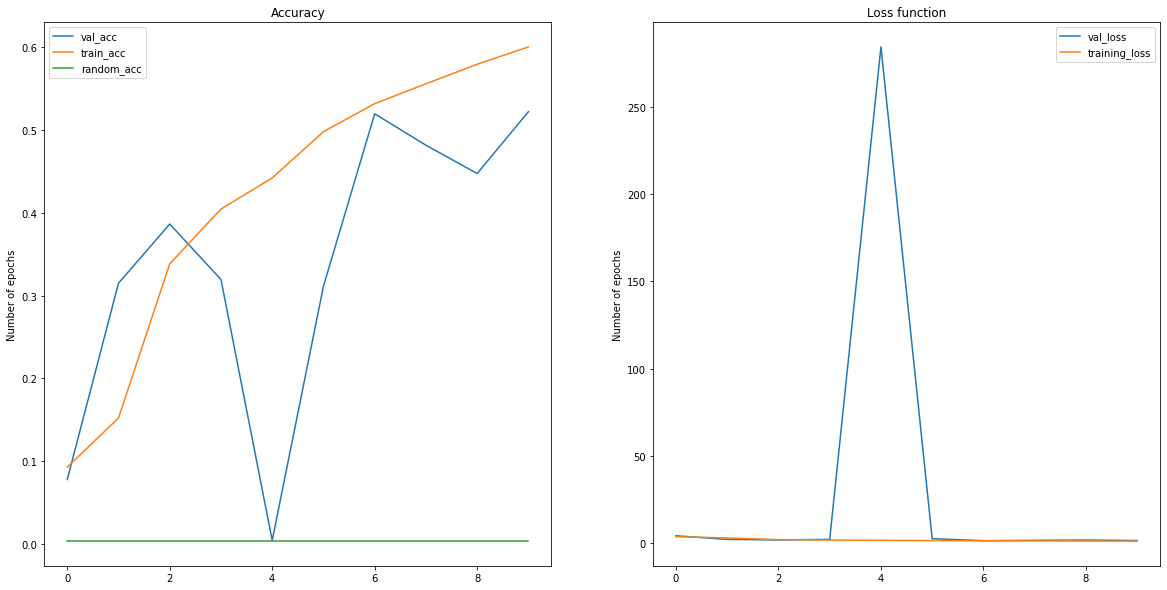

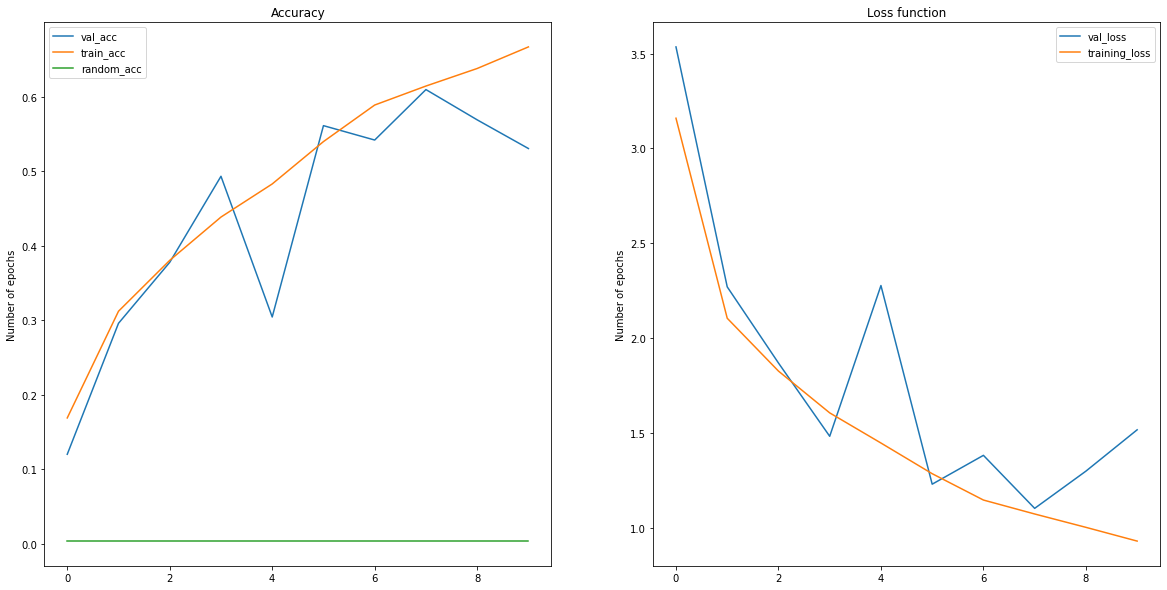

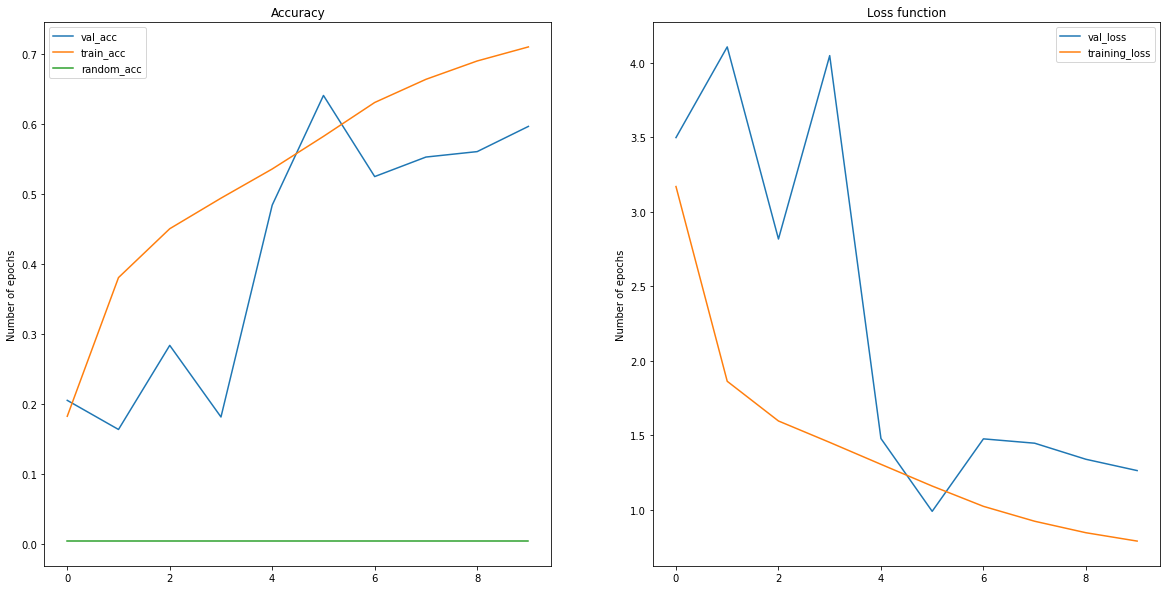

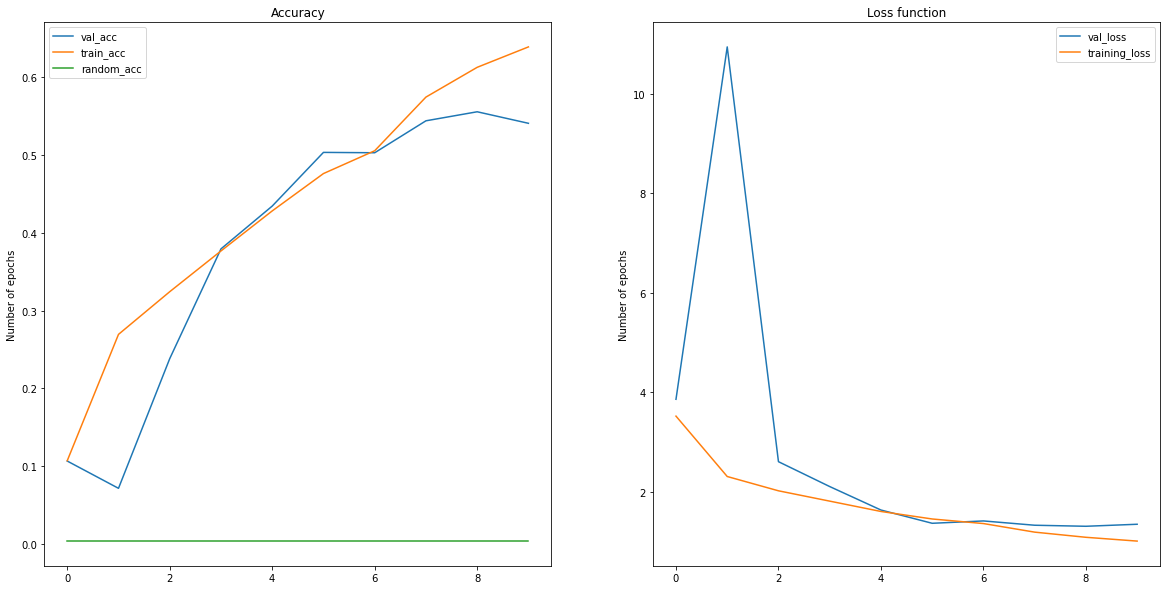

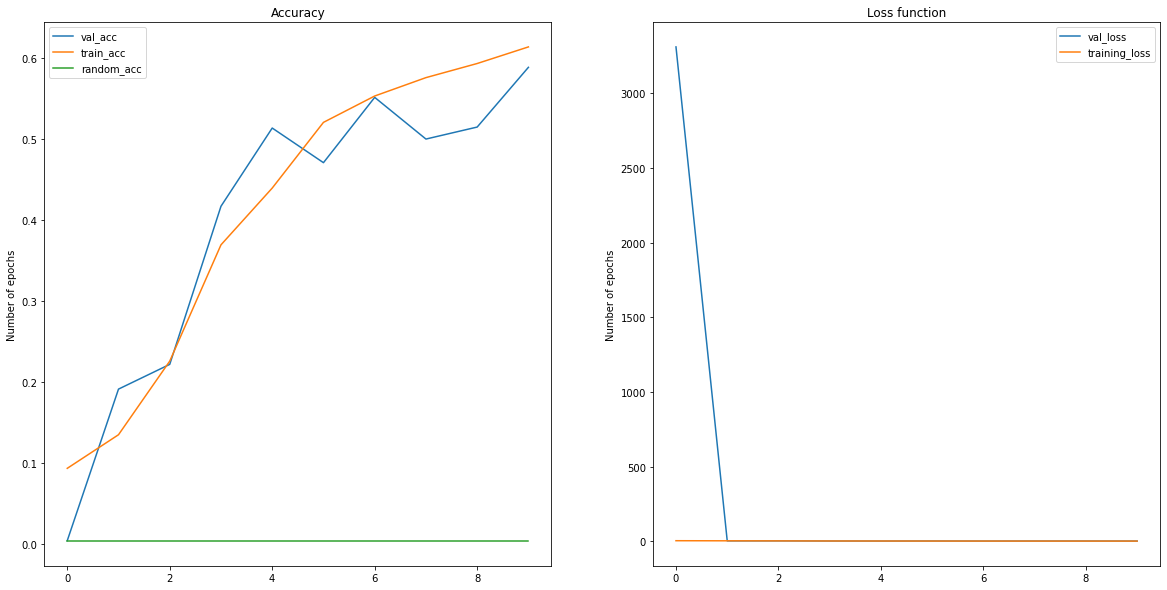

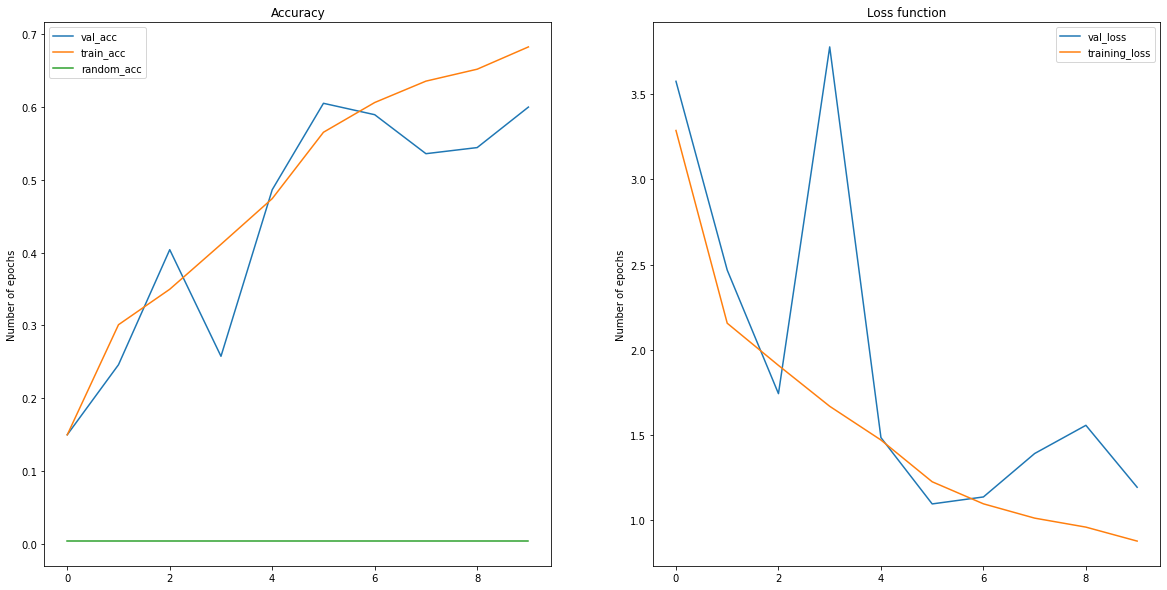

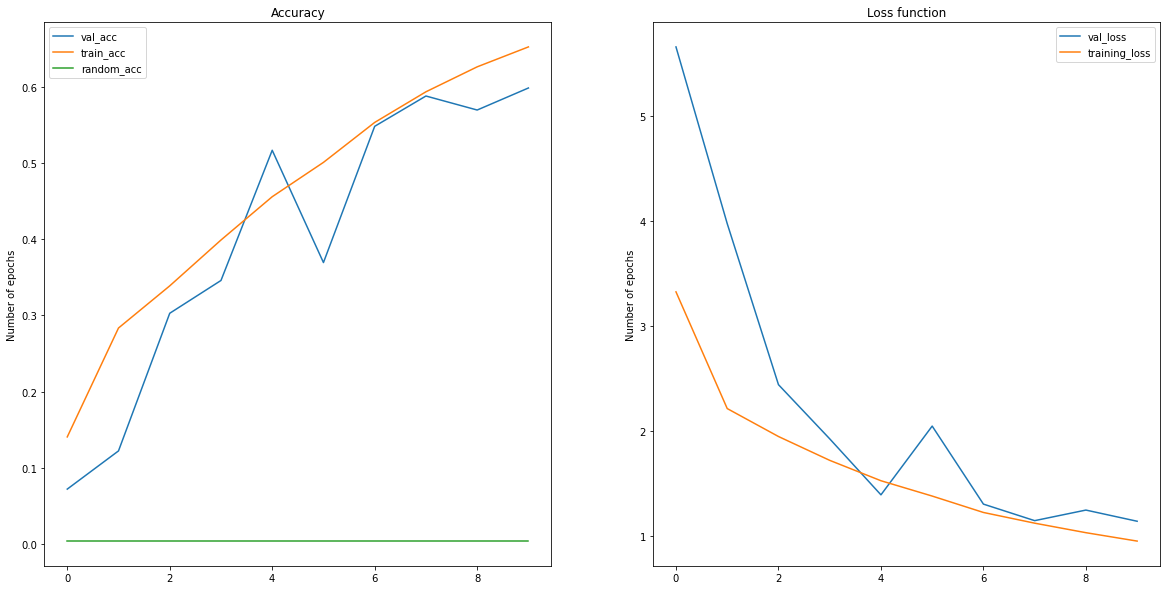

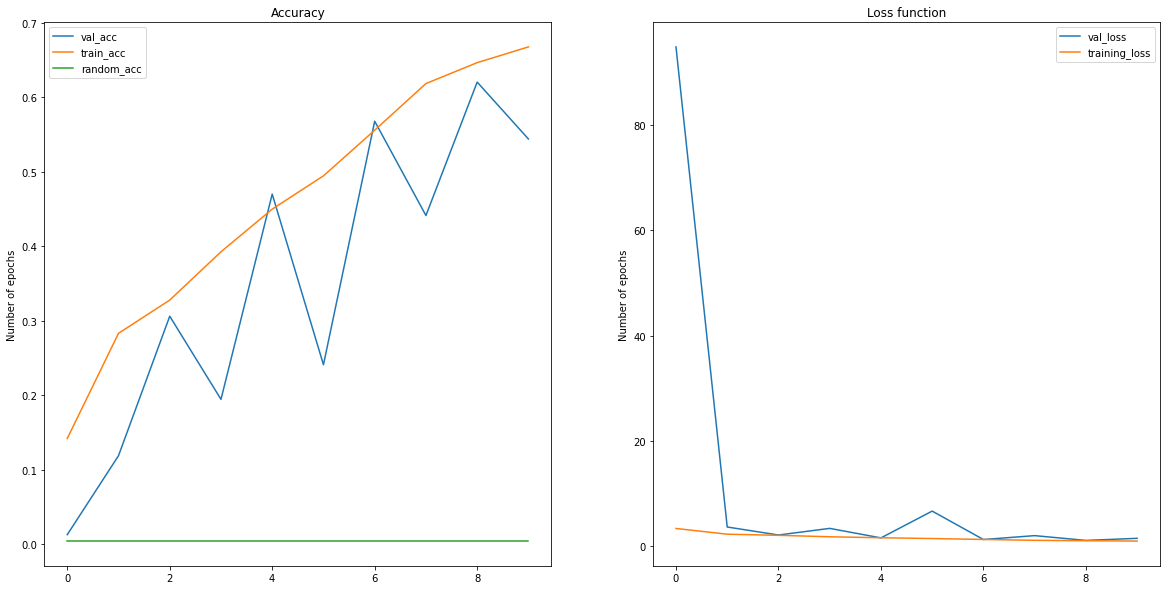

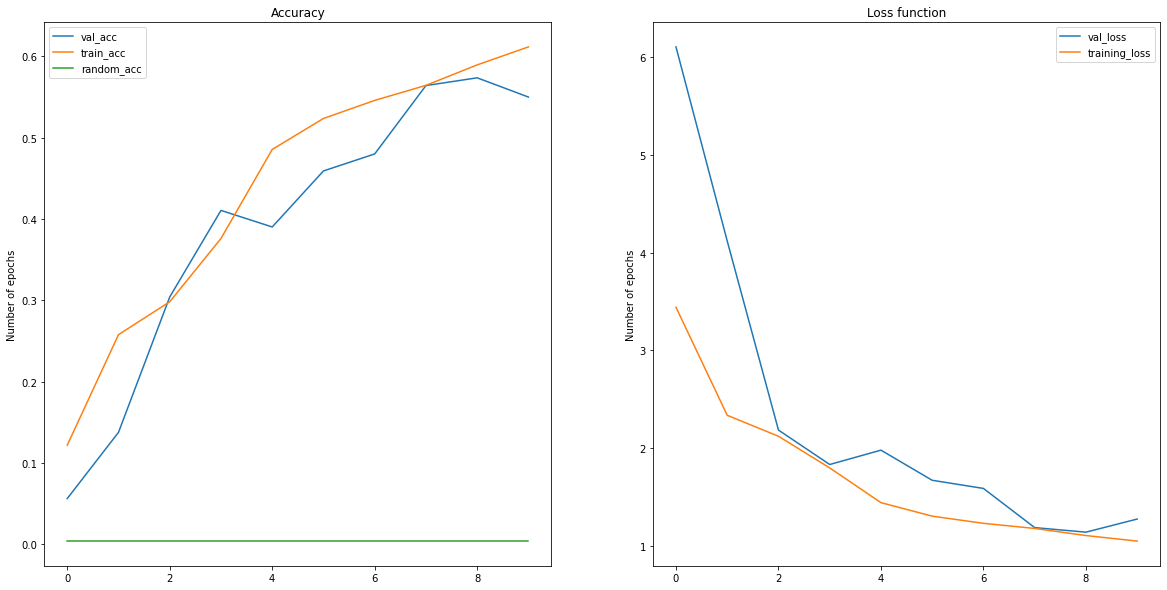

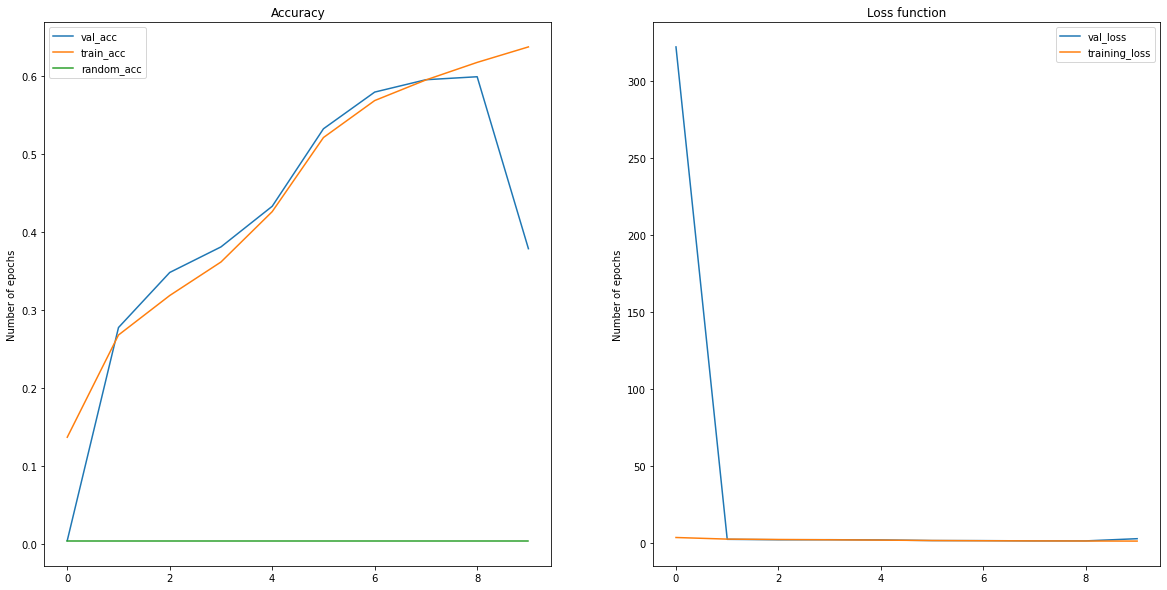

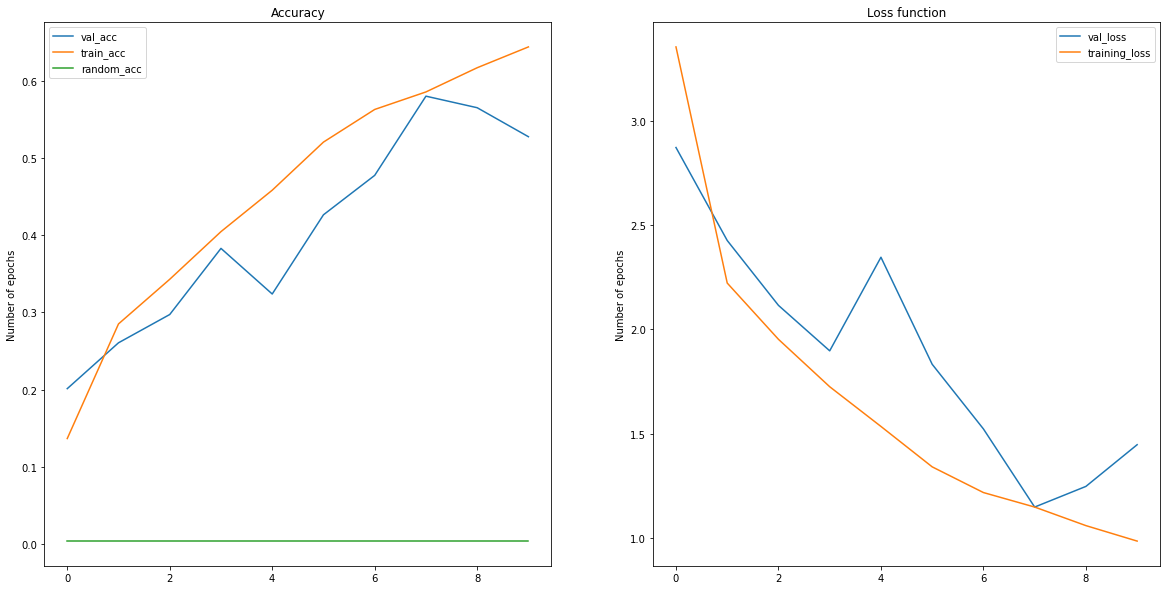

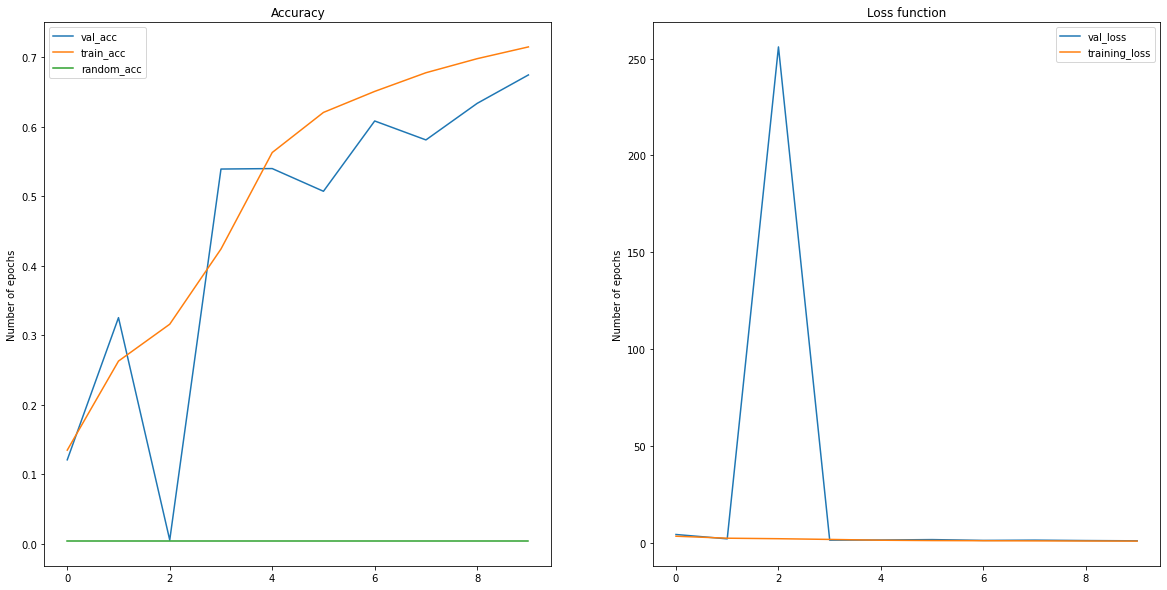

In [41]:
# plot training histories:
for t in full_trainer_list:
    t.plot_model_history()

Almost all models show nice accuracy increases; both training and validation data is close together.

In [44]:
full_trainer = SCA_Trainer()
full_trainer.attack_full_key(models_list, full_trainer_list, dataset, key_index=66, verbose=0)

  0%|          | 0/16 [00:00<?, ?it/s]

Recovered 100.0% of the key


[66, 130, 176, 176, 119, 22, 134, 196, 136, 101, 50, 28, 143, 49, 118, 140]

In [90]:
list(range(1, 3))

[1, 2]

In [92]:
full_trainer.evaluate_attack(models_list, dataset, 10, max_traces=2)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Recovered 68.75% of the key using 1 traces


  0%|          | 0/16 [00:00<?, ?it/s]

Recovered 68.75% of the key using 2 traces


  0%|          | 0/16 [00:00<?, ?it/s]

Recovered 56.25% of the key using 1 traces


  0%|          | 0/16 [00:00<?, ?it/s]

Recovered 62.5% of the key using 2 traces


  0%|          | 0/16 [00:00<?, ?it/s]

Recovered 50.0% of the key using 1 traces


  0%|          | 0/16 [00:00<?, ?it/s]

Recovered 68.75% of the key using 2 traces


  0%|          | 0/16 [00:00<?, ?it/s]

Recovered 43.75% of the key using 1 traces


  0%|          | 0/16 [00:00<?, ?it/s]

Recovered 56.25% of the key using 2 traces


  0%|          | 0/16 [00:00<?, ?it/s]

Recovered 56.25% of the key using 1 traces


  0%|          | 0/16 [00:00<?, ?it/s]

Recovered 68.75% of the key using 2 traces


  0%|          | 0/16 [00:00<?, ?it/s]

Recovered 75.0% of the key using 1 traces


  0%|          | 0/16 [00:00<?, ?it/s]

Recovered 75.0% of the key using 2 traces


  0%|          | 0/16 [00:00<?, ?it/s]

Recovered 81.25% of the key using 1 traces


  0%|          | 0/16 [00:00<?, ?it/s]

Recovered 81.25% of the key using 2 traces


  0%|          | 0/16 [00:00<?, ?it/s]

Recovered 43.75% of the key using 1 traces


  0%|          | 0/16 [00:00<?, ?it/s]

Recovered 62.5% of the key using 2 traces


  0%|          | 0/16 [00:00<?, ?it/s]

Recovered 68.75% of the key using 1 traces


  0%|          | 0/16 [00:00<?, ?it/s]

Recovered 87.5% of the key using 2 traces


  0%|          | 0/16 [00:00<?, ?it/s]

Recovered 56.25% of the key using 1 traces


  0%|          | 0/16 [00:00<?, ?it/s]

Recovered 62.5% of the key using 2 traces
Model failed to recover any keys using [1-2] traces.
